In [1]:
from os import listdir
from os.path import isfile, join
# Import Packages and setup
import numpy as np
import scarlet
import scarlet.display
import astropy.io.fits as fits
from astropy.wcs import WCS
from scarlet.display import AsinhMapping
from scarlet import Starlet
from scarlet.wavelet import mad_wavelet
import scipy.stats as scs
from scarlet.initialization import build_initialization_coadd
from functools import partial
import collections
from scarlet_extensions.initialization.detection import makeCatalog, Data

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# use a better colormap and don't interpolate the pixels
matplotlib.rc('image', cmap='gist_stern')
matplotlib.rc('image', interpolation='none')
from astropy.nddata import Cutout2D
import warnings
warnings.simplefilter("ignore")

In [24]:
# First we load the data and organise them as a cube
path = '/Users/remy/Desktop/git_repos/LSBG_wavelets/Data/'


#So far the only values of i that work are 6, 7, 12, 14, 15, 17, 18, 19, 22, 25
i = '19' #Only psfs available
bands = ['G', 'R', 'I', 'Z', 'Y']

cube = []
psfs = []
for b in bands:
    file = [f for f in listdir(path+'HSC_'+b) if (f[0] == i or f[:2] == i)][0]
    if i in ['6','18']:
        ipsf = i
    else:
        ipsf = '6' #Use the psf for image 6 if no psf exists
    psf_file = [f for f in listdir(path+'psf-'+b) if (f[0] == ipsf or f[:2] == ipsf)][0]
    
    hdu_HSC = fits.open(path+'HSC_'+b+'/'+file)
    hdu_PSF = fits.open(path+'psf-'+b+'/'+psf_file)
    
    psf = hdu_PSF[0].data
    if np.shape(psf)[0] != 41:
        psf = psf[1:-1,:]
    if np.shape(psf)[1] != 41:
        psf = psf[:,1:-1]
    
    cube.append(hdu_HSC[1].data)
    psfs.append(psf)
    
wcs = WCS(hdu_HSC[1].header)
#hdus = fits.PrimaryHDU(np.array(cube), header = hdu_HSC[1].header)
#lists = fits.HDUList([hdus])
#lists.writeto(F'{i}_hsc_cube.fits', clobber=True)

#hdus = fits.PrimaryHDU(np.array(psfs), header = hdu_PSF[0].header)
#lists = fits.HDUList([hdus])
#lists.writeto(F'{i}_hsc_psfs.fits', clobber=True)

cube = np.array(cube)
psfs = np.array(psfs)
channels = ['g','r','i','z','y']

In [25]:
#Detection step. we identify all the source that we have to model.
wave = True #True means wavelet detection. False is regular detection with sep. True is advised in this specific case

if i in ['6', '7']:
    lvl = 4 #Level detection in multiples of noise levels. 
else:
    lvl = 2
#Lower to get more faint sources. For source '6' and '7', lvl=4 is good, but for most other sources (25 for instance) you need to go down to 2 if you want to pick on the faint blended blobs

catalog_hsc, bg_rms_hsc = makeCatalog(cube, lvl, wave)

weights = np.ones_like(cube) / (bg_rms_hsc**2)[:, None, None]

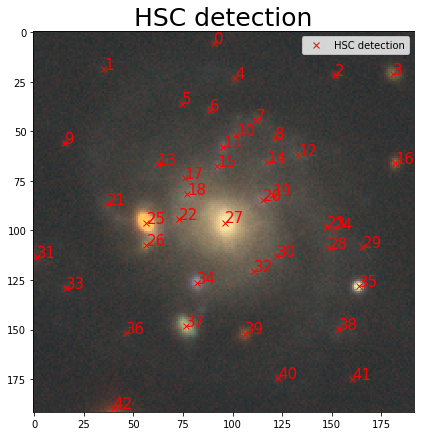

In [26]:
# Create a color mapping for the HSC image
hsc_norm = AsinhMapping(minimum=-1, stretch=5, Q=1)

# Get the source coordinates from the HST catalog
xc,yc = catalog_hsc['x'], catalog_hsc['y']
rac, decc= wcs.wcs_pix2world(yc,xc, 0)
# Convert the HST coordinates to the HSC WCS
# Map the HSC image to RGB
img_rgb = scarlet.display.img_to_rgb(cube, norm=hsc_norm)

plt.figure(figsize=(21,7))

plt.imshow(img_rgb)
#plt.axis('off')

for k, x in enumerate(xc):
    plt.text(xc[k], yc[k], str(k), color="r", fontsize = 15)
plt.plot(xc,yc, 'xr', label = 'HSC detection')
plt.legend()
plt.title("HSC detection", fontsize = 25)

plt.show()

In [27]:
#Scarlet specific preparations:
#We let scarlet know about where the data lives
obs_hsc = scarlet.Observation(cube, wcs=wcs, psfs=psfs, channels=channels, weights=weights)

from functools import partial
#Target psf: Determines to which psf the model is deconvolved. Using the same as in observations leads to no deconvolution
#Remove psfs and uncomment for partial deconvolution
model_psf = scarlet.PSF(partial(scarlet.psf.gaussian, sigma=.8), shape=(None, 8, 8))

#We let scarlet know in what frame we want our models to live
HSC_frame = scarlet.Frame(
    cube.shape,
    wcs = wcs,
    psfs=model_psf,
    channels=channels)
#Observations meet model. Computes operators that project models onto observations
obs_hsc.match(HSC_frame)

In [28]:
#Display function
def display_init(blend, obs, data, ids, img, title, save = False):
    # Load the model and calculate the residual
    model = blend.get_model()
    model = obs.render(model)
    
    init_rgb = scarlet.display.img_to_rgb(model, norm=hsc_norm)
    residual = data - model
    
    residual_rgb = scarlet.display.img_to_rgb(residual[:,:])
    vmax = np.max(np.abs(residual_rgb))
    if residual_rgb.shape[0]<2:
        residual_rgb = residual_rgb[0,:,:]
        print('zizi')
    plt.figure(ids,figsize=(20, 8))
    plt.suptitle(title, fontsize=36)
    plt.subplot(131)
    plt.imshow(img)
    plt.axis('off')
    plt.title("Data", fontsize=20)
    plt.subplot(132)
    plt.imshow(init_rgb)
    plt.axis('off')
    plt.title("Model", fontsize=20)
    plt.subplot(133)
    plt.imshow(residual_rgb, vmin=-vmax, vmax=vmax, cmap = 'seismic')
    plt.axis('off')
    plt.title("Residuals", fontsize=20)
    if save is True:
        plt.savefig(title+'_'+str(coord[0])+'_'+str(coord[1])+'.png')
    pass

No flux above threshold for source at y=5 x=90
No flux above threshold for source at y=18 x=35
No flux above threshold for source at y=21 x=151
No flux above threshold for source at y=23 x=101
No flux above threshold for source at y=35 x=74
No flux above threshold for source at y=39 x=88
No flux above threshold for source at y=44 x=111
No flux above threshold for source at y=53 x=121
No flux above threshold for source at y=56 x=15
No flux above threshold for source at y=61 x=133
No flux above threshold for source at y=66 x=62
No flux above threshold for source at y=86 x=36
No flux above threshold for source at y=98 x=147
No flux above threshold for source at y=99 x=151
No flux above threshold for source at y=108 x=148
No flux above threshold for source at y=108 x=165
No flux above threshold for source at y=113 x=1
No flux above threshold for source at y=128 x=15
No flux above threshold for source at y=151 x=46
No flux above threshold for source at y=149 x=153
No flux above threshold fo

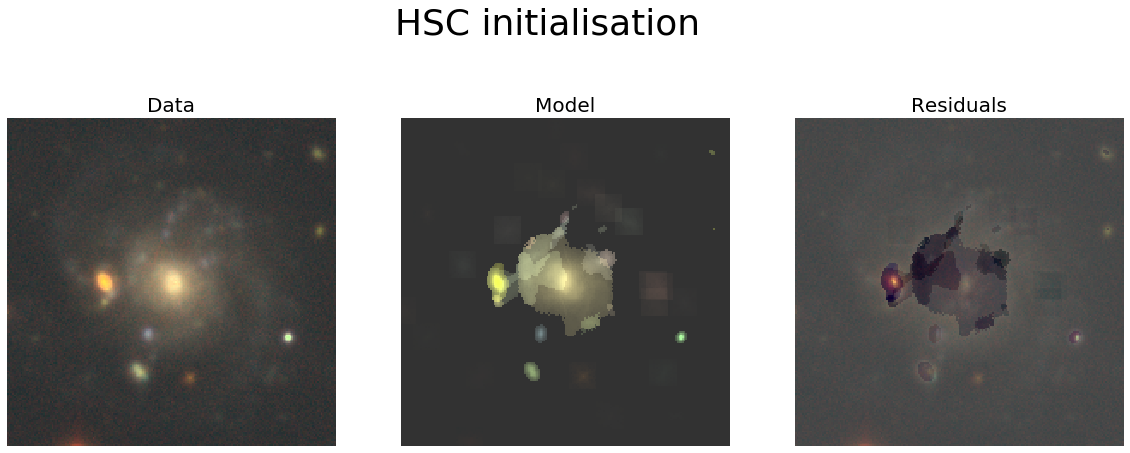

In [29]:
# Building a detection coadd
coadd, bg_cutoff = build_initialization_coadd(obs_hsc)

# Source initialisation: MAkes a first guess as to te source profiles and seds
#Here all sources are extended sources which is a sort of a vaniulla agnostic scarlet run.
HSC_sources = [
    scarlet.ExtendedSource(HSC_frame, (rac[i], decc[i]), obs_hsc, 
                           symmetric=False, 
                           monotonic=True, 
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           min_grad = 0)
    for i in range(rac.size)
]

blend_hsc = scarlet.Blend(HSC_sources, obs_hsc)
display_init(blend_hsc, obs_hsc, cube, 0, img_rgb, 'HSC initialisation')

scarlet ran for 100 iterations to logL = -91001.91353366023


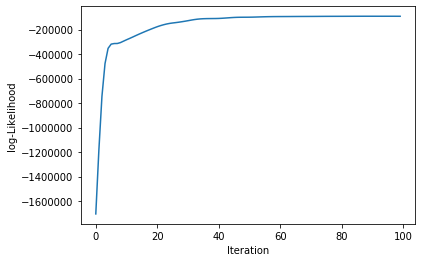

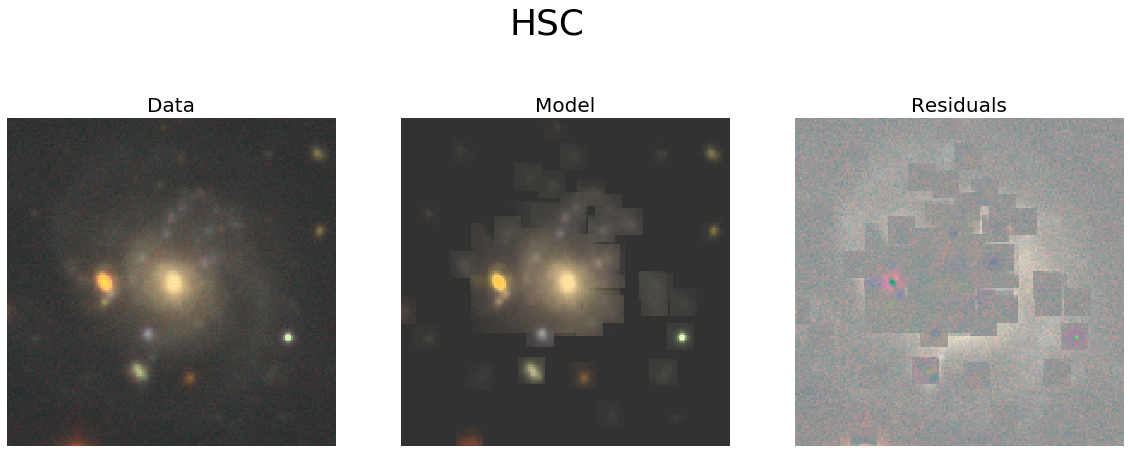

In [30]:
#Runs vanilla scarlet and plots convergence
blend_hsc.fit(100, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_hsc.loss), -blend_hsc.loss[-1]))
plt.plot(-np.array(blend_hsc.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_hsc, obs_hsc, cube, 0, img_rgb, 'HSC', save = 0)

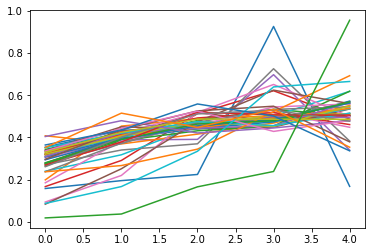

In [31]:
seds = []
for s in blend_hsc.sources:
    sed = np.copy(s.sed)
    sed/=np.sqrt(np.sum(sed**2))
    seds.append(sed)
    plt.plot(sed)
plt.show()


(43, 5)


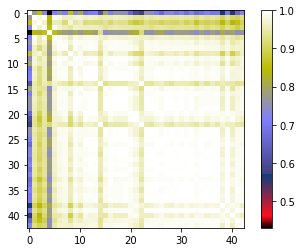

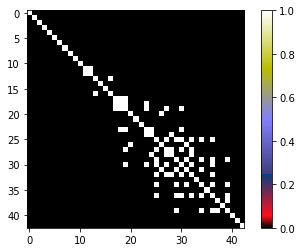

In [145]:
seds = np.array(seds)
sort_seds = seds[np.argsort(seds[:,0]), :]
print(seds.shape)
cov = np.sum(sort_seds[:,None,:]*sort_seds[None,:,:], axis = -1)
plt.imshow(cov)
plt.colorbar()
plt.show()
cov[cov<0.999] = 0
plt.imshow(cov)
plt.colorbar()
plt.show()

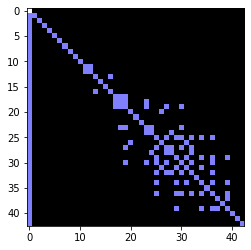

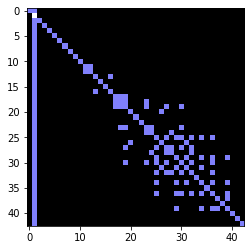

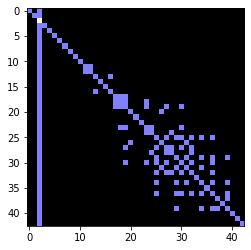

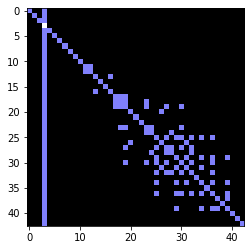

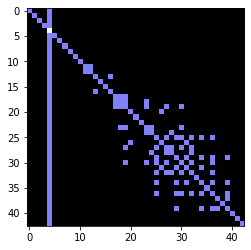

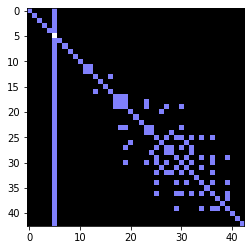

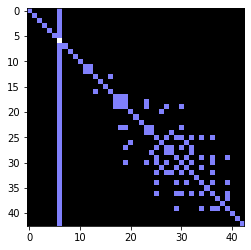

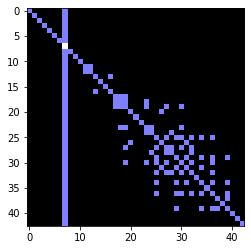

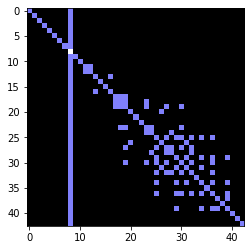

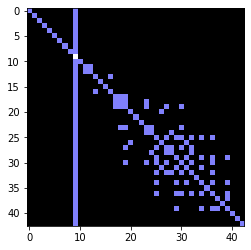

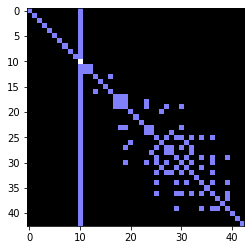

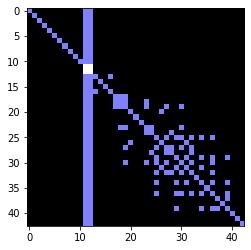

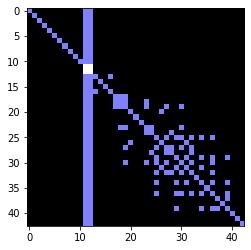

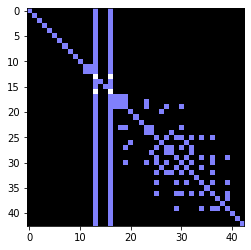

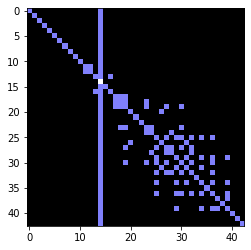

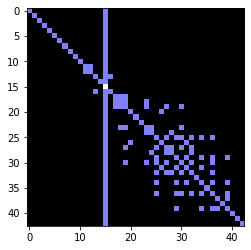

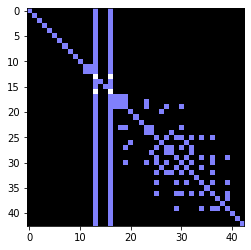

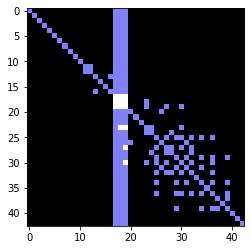

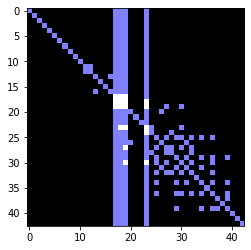

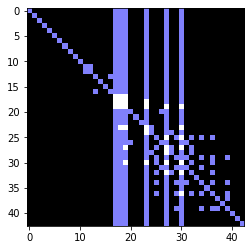

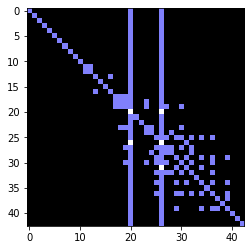

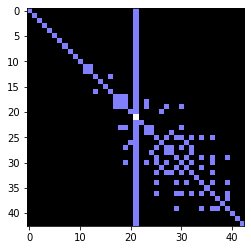

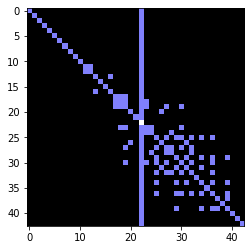

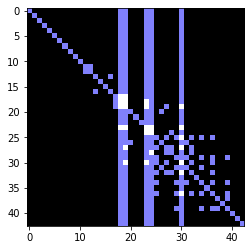

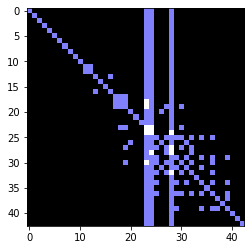

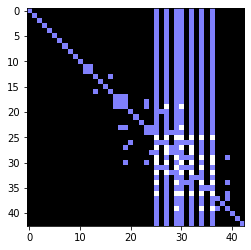

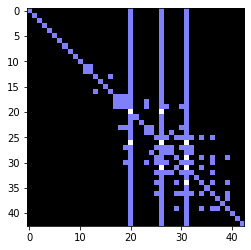

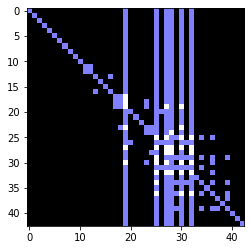

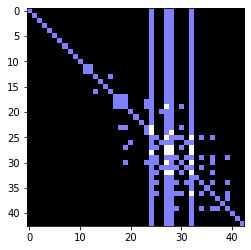

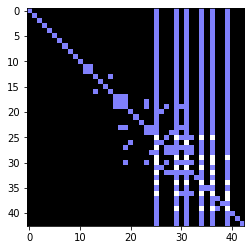

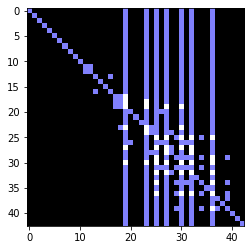

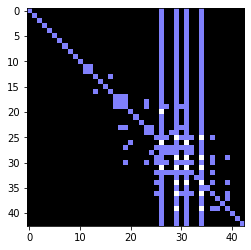

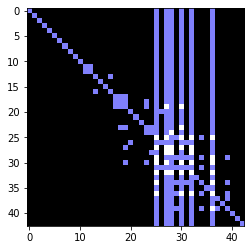

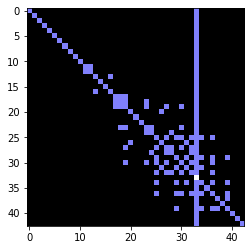

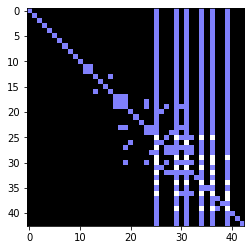

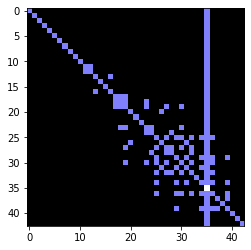

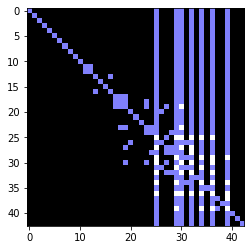

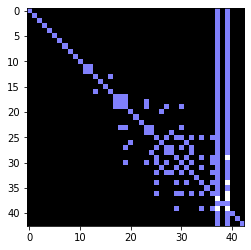

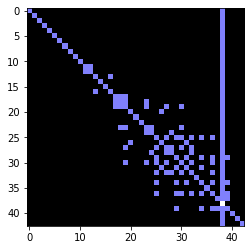

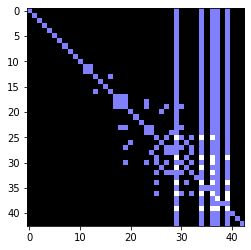

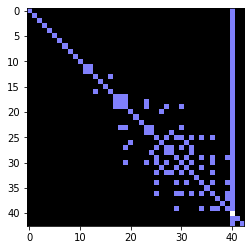

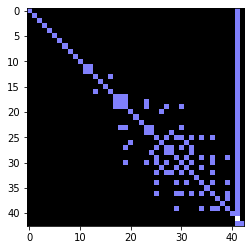

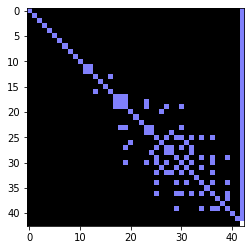

0


In [144]:
def group(cov, thresh = 0.999):
    groups = []
    cov[cov<thresh] = 0
    cov[cov>=thresh] = 1
    
    for i,c in enumerate(cov):
        groups.append([*np.where(c==1)[0]])
        
    intersect = 1
    groupses = []
    while intersect is 1:
        for g in groups:
            ind_group = g
            for gg in groups:
                if np.intersect(g,gg).size > 0:
                    ind_group += gg
                 

    return 0
    
print(group(cov,thresh = 0.999))

In [11]:
#Now let's try with wavelets: 

#Source initialisation. Here we decide which sources from the detection step should be modeled with wavelets.
from scarlet import StarletSource
#Keep in mind that the choices made here were for a given source detection level. Most of them are set for lvl=2. Source 6 needs lvl = 4.
#If results look weird, try to changing the detection lvl to obtain something that makes sense. 
if i == '18':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==23 or i == 25:
        
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                           (rac[i], decc[i]), obs_hsc,  
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           spectrum = sedi,
                           min_grad = 0, 
                                  starlet_thresh = 3)
            wave_sources[i] = newsource

elif i =='6':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==1 or i==8:
            
            sedi = np.copy(HSC_sources[i].sed)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                               starlet_thresh = 3)
            wave_sources[i] = newsource
    wave_sources =np.delete(wave_sources, 12)
    wave_sources =np.delete(wave_sources, 7)
elif i =='25':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==32 or i == 44:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='12':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==13 or i == 28:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='7':
    wave_sources = []#np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==10 or i == 11:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                                starlet_thresh = 3)
            wave_sources.append(newsource)
        if i==19 or i==20 or i==1 or i==5 or i==6 or i==15 or i==14:
            newsource = scarlet.ExtendedSource(HSC_frame, (rac[i], decc[i]), obs_hsc, 
                           symmetric=False, 
                           monotonic=True, 
                           coadd=coadd, 
                           bg_cutoff=bg_cutoff,
                           min_grad = 0)
            wave_sources.append(newsource)
elif i =='22':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==17 or i == 16:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
            
elif i =='19':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==27 or i == 28:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='17':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==3:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                               starlet_thresh = 3)
            wave_sources[i] = newsource
elif i =='15':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==14:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                               starlet_thresh = 3)
            wave_sources[i] = newsource   
elif i =='14':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==5:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                               starlet_thresh = 3)
            wave_sources[i] = newsource   
    
    wave_sources = np.delete(wave_sources, 9)
    wave_sources = np.delete(wave_sources, 7)    
    wave_sources = np.delete(wave_sources, 6)
    wave_sources = np.delete(wave_sources, 4)
elif i =='10':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==17 or i==28:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                               starlet_thresh = 3)
            wave_sources[i] = newsource   
    wave_sources = np.delete(wave_sources, 31) 
    wave_sources = np.delete(wave_sources, 29) 
    wave_sources = np.delete(wave_sources, 23) 
    wave_sources = np.delete(wave_sources, 19)
    wave_sources = np.delete(wave_sources, 16) 
    wave_sources = np.delete(wave_sources, 18)    
    wave_sources = np.delete(wave_sources, 15)
elif i =='5':
    wave_sources = np.copy(HSC_sources)
    for i in range(len(HSC_sources)):
        if i ==21 or i == 22 or i == 19:
            
            sedi = np.copy(HSC_sources[i].spectrum)
            newsource = StarletSource(HSC_frame, 
                               (rac[i], decc[i]), obs_hsc,  
                               coadd=coadd, 
                               bg_cutoff=bg_cutoff,
                               spectrum = sedi,
                               min_grad = 0, 
                                      starlet_thresh = 3)
            wave_sources[i] = newsource   

    wave_sources = np.delete(wave_sources, 26) 
    wave_sources = np.delete(wave_sources, 25)    
    wave_sources = np.delete(wave_sources, 24)
    wave_sources = np.delete(wave_sources, 23) 
    wave_sources = np.delete(wave_sources, 18) 
    wave_sources = np.delete(wave_sources, 16) 
    wave_sources = np.delete(wave_sources, 15)
    wave_sources = np.delete(wave_sources, 14) 
    wave_sources = np.delete(wave_sources, 13)    
    wave_sources = np.delete(wave_sources, 12)

TypeError: __init__() got an unexpected keyword argument 'spectrum'

In [ ]:
#Display first guess with wavelets
blend_wavehsc = scarlet.Blend(wave_sources, obs_hsc)

display_init(blend_wavehsc, obs_hsc, cube, 0, img_rgb, 'HSC initialisation')

In [ ]:
#Runs scarlet with wavelets
blend_wavehsc.fit(500, e_rel = 1.e-7)
print("scarlet ran for {0} iterations to logL = {1}".format(len(blend_wavehsc.loss), -blend_wavehsc.loss[-1]))
plt.plot(-np.array(blend_wavehsc.loss))
plt.xlabel('Iteration')
plt.ylabel('log-Likelihood')
display_init(blend_wavehsc, obs_hsc, cube, 0, img_rgb, 'HSC initialisation')

In [ ]:
#Show results
hsc_norm = AsinhMapping(minimum=-1, stretch=3, Q=1)

scarlet.display.show_sources(wave_sources, 
                             norm=hsc_norm, 
                             observation=obs_hsc,
                             show_rendered=True, 
                             show_observed=True)
plt.show()